# Simulation plots

==BASICS==

For 40 genes and 10 spikes
- 500: 77.340
- 1000: 149.159
- 5000: 1398.347
- 10000: 2433.064
- 20000: 4021.876
- 50000: 8715.963
- 100000: 16965.28

For 200 genes and 10 spikes
- 500: 294.071


==scHOT==

For 3 genes
- 500: 5.545
- 1000: 6.392
- 2000: 8.199
- 10000: 29.747
- 50000: 216.559
- 100000: 273.492

In [1]:
import scanpy as sc
import anndata
import time
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from pybedtools import BedTool
import pickle as pkl
import scipy as sp

%matplotlib inline

In [33]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'small',
         'axes.labelsize': 'medium',
         'axes.titlesize':'medium',
         'figure.titlesize':'medium',
         'xtick.labelsize':'small',
         'ytick.labelsize':'small'}
pylab.rcParams.update(params)


In [2]:
import sys
sys.path.append('/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.6-py3.8.egg')
sys.path.append('/home/ssm-user/Github/misc-seq/miscseq/')
import encode
import memento
from memento import simulate

In [3]:
data_path = '/data_volume/memento/simulation/'

### Get runtimes for other methods

In [17]:
basics_nc = np.array([500, 1000, 5000, 10000, 20000, 50000, 100000])
basics_runtime = np.array([77, 150, 1400, 2430, 4020, 8715, 17000])/40

schot_nc = np.array([500, 1000, 2000, 10000, 50000, 100000])
schot_runtime = np.array([5.545, 6.392, 8.199, 29.747, 216.559, 273.492])/3

memento_nc =  np.array([250, 500, 2500, 5000, 10000, 50000, 100000, 500000])*2
memento_runtime = np.array([
    0.014873566601481314, 
    0.01777667029552868,
    0.021939572579455825,
    0.022748108507940443,
    0.027120769728360652,
    0.03643204177761024,
    0.04465434376358209,
    0.11130434910770462])

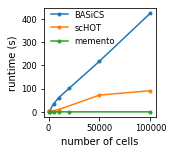

In [54]:
plt.figure(figsize=(2, 2))
plt.plot(basics_nc, basics_runtime, 'o-', markersize=3)
plt.plot(schot_nc, schot_runtime, 'o-', markersize=3)
plt.plot(memento_nc[:-2], memento_runtime[:-2], 'o-', markersize=3);
plt.ylabel('runtime (s)'); plt.xlabel('number of cells')
plt.legend(['BASiCS', 'scHOT', 'memento'], frameon=False, bbox_to_anchor=(0.35,1.05), ncol=1, loc='upper center')
plt.savefig('all_runtimes.pdf', bbox_inches='tight')

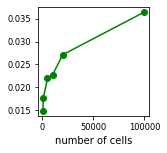

In [56]:
plt.figure(figsize=(2, 2))

plt.plot(memento_nc[:-2], memento_runtime[:-2], 'o-', color='g');
plt.xlabel('number of cells')
plt.savefig('memento_runtimes.pdf', bbox_inches='tight')
# plt.legend(['memento'], frameon=False, bbox_to_anchor=(0.35,1.05), ncol=1, loc='upper center')

### Get runtimes for memento

In [4]:
nc_list = [250, 500, 2500, 5000, 10000, 50000, 100000, 500000]

In [7]:
for nc in [100000]:
    
    if nc > 5000:
        
        num_to_merge = int(nc/5000)
        adata_list = []
        for i in range(num_to_merge):
            adata_list.append(sc.read(data_path + 'runtime/5000_{}.h5ad'.format(i)))
        adata = anndata.concat(adata_list)
    elif nc == 5000:
        adata = sc.read(data_path + 'runtime/5000_0.h5ad'.format(nc))
    else:
        adata = sc.read(data_path + 'runtime/{}.h5ad'.format(nc))
    adata.obs['q'] = 0.07
    memento.setup_memento(adata, q_column='q', filter_mean_thresh=0.03)
    memento.create_groups(adata, label_columns=['ct_real'])

    memento.compute_1d_moments(adata, min_perc_group=.9)
    
    start = time.time()
    memento.ht_1d_moments(
        adata, 
        formula_like='1 + ct_real',
        treatment_col='ct_real', 
        num_boot=1000, 
        verbose=1,
        num_cpus=1,
        resampling='permutation',
        approx=True)
    end = time.time()
    
    print('Nc', nc, '--------------------')
    print('walltime', (end-start)/adata.shape[1])
    print('num genes', adata.shape[1], 'num cells', adata.shape[0])

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Version 0.0.6


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Nc 100000 --------------------
walltime 0.04482535666360696
num genes 3531 num cells 200000


[Parallel(n_jobs=1)]: Done 3531 out of 3531 | elapsed:  2.6min finished
